In [25]:
# Upwelled water plume
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

In [26]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
        ----------
        y : array_like, shape (N,)
           the values of the time history of the signal.
       window_size : int
           the length of the window. Must be an odd integer number.
       order : int
           the order of the polynomial used in the filtering.
           Must be less then `window_size` - 1.
       deriv: int
           the order of the derivative to compute (default = 0 means only smoothing)
       Returns
       -------
       ys : ndarray, shape (N)
           the smoothed signal (or it's n-th derivative).
       Notes
       -----
       The Savitzky-Golay is a type of low-pass filter, particularly
       suited for smoothing noisy data. The main idea behind this
       approach is to make for each point a least-square fit with a
       polynomial of high order over a odd-sized window centered at
       the point.
       Examples
       --------
       t = np.linspace(-4, 4, 500)
       y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
       ysg = savitzky_golay(y, window_size=31, order=4)
       import matplotlib.pyplot as plt
       plt.plot(t, y, label='Noisy signal')
       plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
       plt.plot(t, ysg, 'r', label='Filtered signal')
       plt.legend()
       plt.show()
       References
       ----------
       .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
          Data by Simplified Least Squares Procedures. Analytical
          Chemistry, 1964, 36 (8), pp 1627-1639.
       .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
         W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
          Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
   
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
  
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
  
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
  
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def arrayExpand(array,Tr, dim=0):
    '''Expand the dimensions of array along dimension dim to fit those of Tr. Array should have one dimension less than Tr (time axis=0). 
    It adds a dimension along axis dim.'''
    arr_expand = np.expand_dims(array, dim)
    arr_expand = arr_expand + np.zeros(Tr.shape)
    return arr_expand

def mask2DCanyon(bathy, sbdepth=-0.0295):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, nx=512, ny=266, sbdepth=-0.0295):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((ny,nx))
    Conc = np.empty((ny,nx))
    ConcFiltered = np.empty((ny,nx))
    Area = np.empty((ny,nx))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd)-1 # Get index of unreversed z axis
    
    for j in range(nx):
        for i in range(ny):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=0.2, cmax=1.8):
    
    BAC = ConcFilt[yslice,xslice]
    levels = np.linspace(cmin,cmax,20) #[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,levels,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.2,1.0],colors='k')
    plt.clabel(cs, fmt='%1.1f', fontsize=10)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

def PlotBdy(ax,ConcFilt,X,Y,xslice,yslice,color):
    
    BAC = ConcFilt[yslice,xslice]
    
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[1.0],colors=color)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)   
                       
    ax.set_aspect(1)
    return(cs)

def PlotPoolsTr(ax1,tslice, key, ptr_fileA, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,sbind,
                sbdepthA=-150,colmap=cmo.cm.delta, pool_min=0.2, pool_max=1.8):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                         xslice_pl,yslice_pl, colmap, cmin=pool_min, cmax=pool_max)

    ax1.set_facecolor("darkgrey")
    ax1.set_aspect(1)
    return(ax1, mesh1)

def PlotPoolBoundary(ax1, tslice, key, ptr_fileA, 
                     xslice_pl, yslice_pl, nz,
                     hFacA, rAA, DepthA, XA, YA,sbind,color,
                     sbdepthA=-150):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotBdy(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                        xslice_pl,yslice_pl,color)

    ax1.set_aspect(1)
    return(ax1)

In [32]:
grid='/Volumes/balaenopter/BF5_from_PIV_two_canyons/run01/gridGlob.nc'
state='/Volumes/balaenopter/BF5_from_PIV_two_canyons/run01/stateGlob.nc'

nx = 512 # theta
ny = 266 # r
nz = 175 

with Dataset(grid, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacC = nbl.variables['HFacC'][:]
    Depth = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacC, 0)
    maskC = np.ma.getmask(hfac)
    rA = nbl.variables['rA'][:]
    
hFacNoC = arrayExpand(hFacC[:,:,320], hFacC, dim=2)
maskCNoC = arrayExpand(maskC[:,:,320], maskC, dim=2)           # Make a no canyon mask
rANoC = rA
 
with Dataset(state, 'r') as nbl:
    time = nbl.variables['T'][:]
nt = np.shape(time)[0]
sb_depth = ZA[int(29.5/0.5)]

In [33]:
# Bottom concetration linear profile (mean during adv. phase)
tslice = slice(6,nt)
sbdepth = -0.0295
with Dataset(state, 'r') as nbl:
    ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables['S'][tslice,:,:,:], axis=0),
                                                 hFacNoC,rA,Depth,nz-1,sbdepth=sbdepth)

(0.1, 0.5)

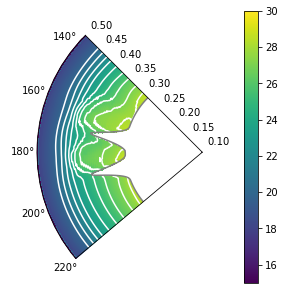

In [48]:
R = YA
Th = np.pi*XA/180
thmesh, rmesh = np.meshgrid(Th,R)
xmesh = rmesh*np.cos(-thmesh)
ymesh = rmesh*np.sin(-thmesh)

fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111, projection='polar')

with Dataset(state, 'r') as nbl:
    S_lim = nbl['S'][0,int(29/0.5),30,255]
pc = ax0.pcolormesh(Th,R,np.fliplr(ConcLinA), vmin=15, vmax=30)
cn = ax0.contour(Th,R,np.fliplr(ConcLinA), levels=[20,21,22,23,24,25,26,27,28], colors='w')

plt.colorbar(pc)
ax0.contour(Th,R,Depth,levels=[0.029],colors='0.5')

ax0.set_xlim(np.pi*135/180,np.pi*220/180)
ax0.set_ylim(0.1,0.5)

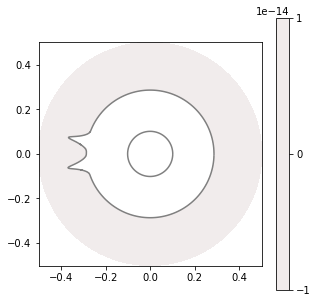

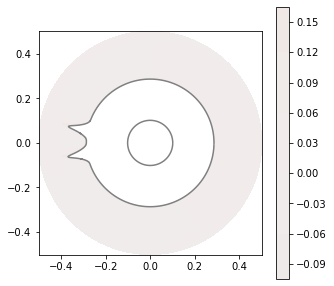

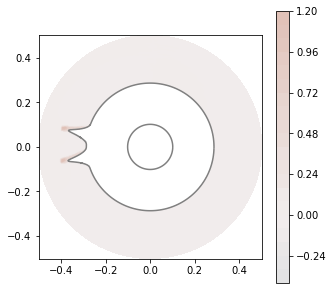

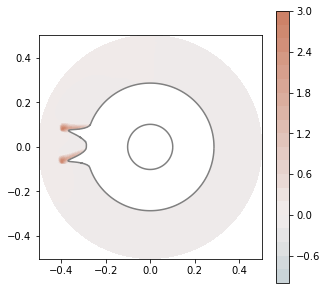

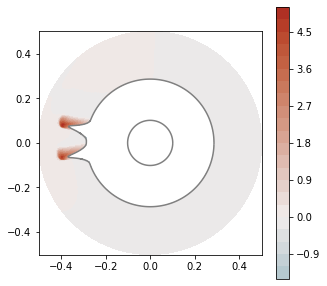

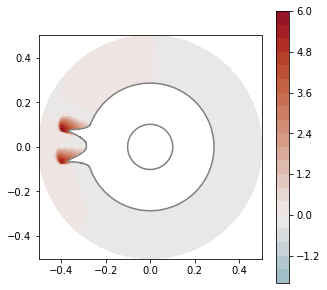

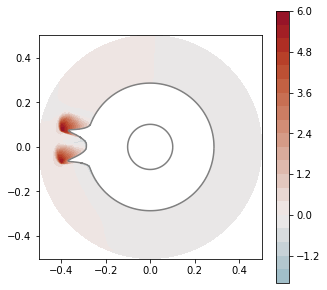

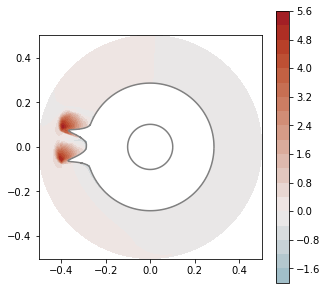

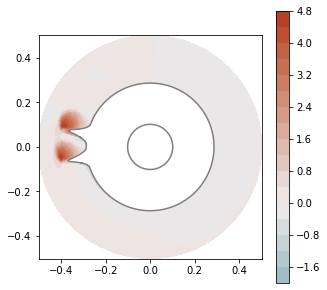

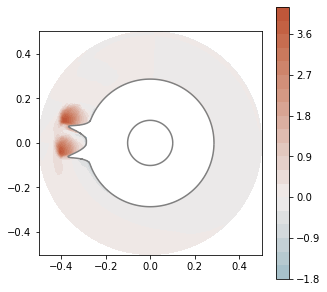

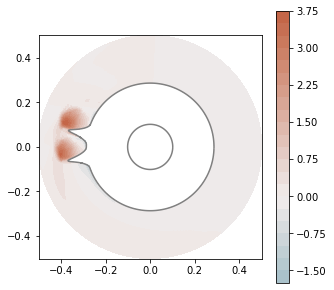

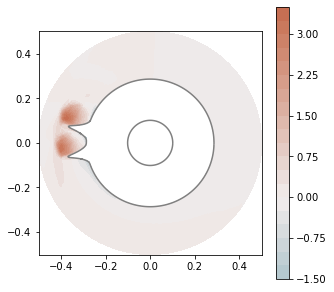

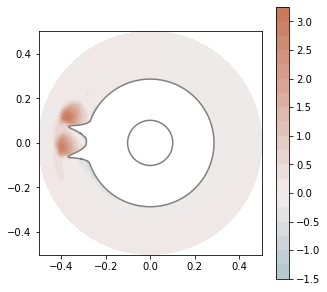

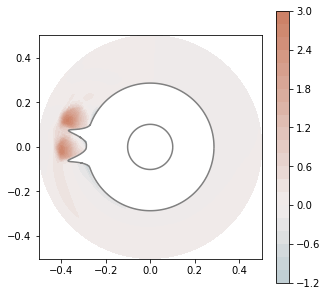

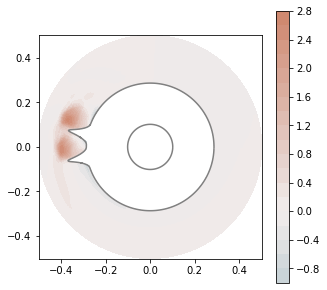

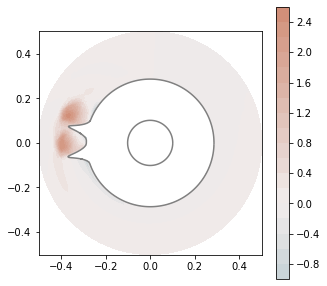

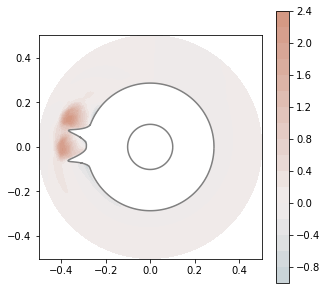

In [52]:
sbdepth = -0.0295
plot_type='cartesian'


for tt in range(len(time)):
    tslice = slice(tt,tt+1)
    with Dataset(state, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables['S'][tslice,:,:,:], axis=0),
                                                     hFacNoC,rA,Depth,nz-1,sbdepth=sbdepth)
    ConcLinBkg = arrayExpand(ConcLinA[:,450], ConcLinA, dim=1)
    
    # polar:
    if plot_type == 'polar':
        fig = plt.figure(figsize=(5,5))
        ax0 = fig.add_subplot(111, projection='polar')
        pc = ax0.contourf(-Th,R,(ConcLinA-ConcLinBkg),20, vmin=-8, vmax=8, cmap=cmo.cm.balance)
        plt.colorbar(pc)
        ax0.contour(-Th,R,Depth,levels=[0.029],colors='0.5')
        ax0.plot(thmesh[:,450], rmesh[:,450], 'g-')
        #ax0.set_xlim(np.pi*90/180,np.pi*270/180)
        ax0.set_ylim(0.1,0.5)
        plt.show()
    else:
        # cartesian:
        fig = plt.figure(figsize=(5,5))
        ax0 = fig.add_subplot(111)
        pc = ax0.contourf(xmesh,ymesh,(ConcLinA-ConcLinBkg),20, vmin=-8, vmax=8, cmap=cmo.cm.balance)
        plt.colorbar(pc)
        ax0.contour(xmesh,ymesh,Depth,levels=[0.029],colors='0.5')
        #ax0.set_xlim(np.pi*90/180,np.pi*270/180)
        #ax0.set_ylim(0.1,0.5)
        ax0.set_aspect(1)
        plt.show()

In [53]:
time

masked_array(data=[ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.,
                   55., 60., 65., 70., 75., 80.],
             mask=False,
       fill_value=1e+20)